In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


## Workflow stages
The competition solution workflow goes through seven stages described in the Data Science Solutions book.

1. Question or problem definition.
1. Acquire training and testing data.
1. Wrangle, prepare, cleanse the data.
1. Analyze, identify patterns, and explore the data.
1. Model, predict and solve the problem.
1. Visualize, report, and present the problem solving steps and final solution.
1. Supply or submit the results.

In [64]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [65]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
combine = [train_df, test_df]

In [66]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [67]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [69]:
train_df.info()
print('_'*40)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null

In [70]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## Assumtions based on data analysis

### Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

### Completing.

1. We may want to complete Age feature as it is definitely correlated to survival.
1. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

### Correcting.

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
1. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
1. PassengerId may be dropped from training dataset as it does not contribute to survival.
1. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

### Creating.

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
1. We may want to engineer the Name feature to extract Title as a new feature.
1. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
1. We may also want to create a Fare range feature if it helps our analysis.

### Classifying.

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
1. Children (Age<?) were more likely to have survived.
1. The upper-class passengers (Pclass=1) were more likely to have survived.

In [72]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [73]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [74]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [75]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


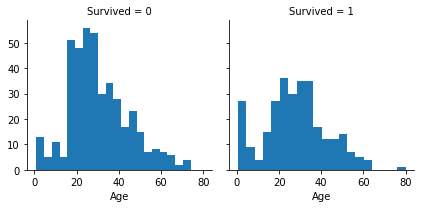

In [76]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


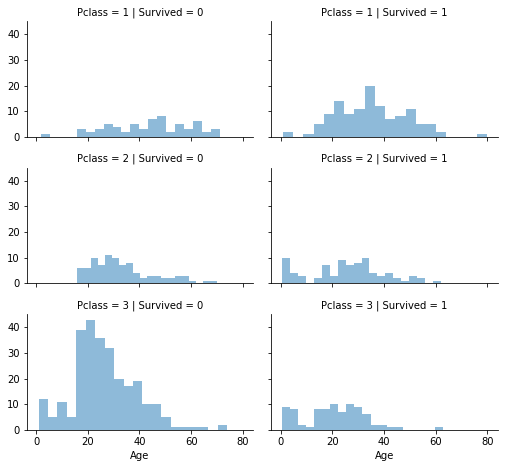

In [77]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


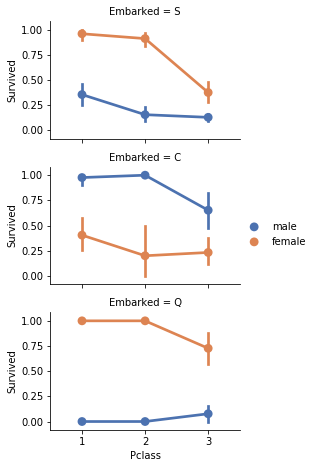

In [78]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


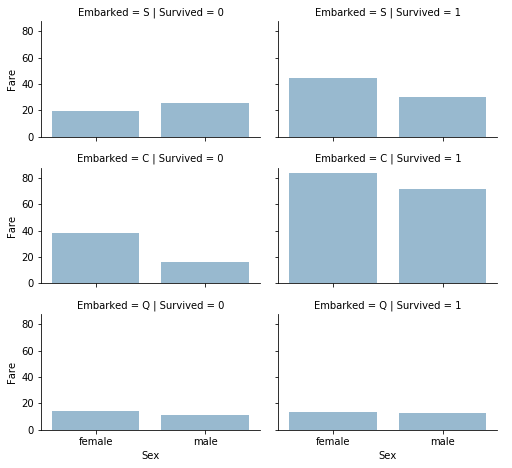

In [79]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size = 2.2, aspect = 1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [80]:
print("Before Dropping: ", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine=[train_df, test_df]
print("After Dropping: ", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before Dropping:  (891, 12) (418, 11) (891, 12) (418, 11)
After Dropping:  (891, 10) (418, 9) (891, 10) (418, 9)


In [81]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [82]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [83]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rate": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,3.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3.0


In [84]:
dataset['Title'] = dataset['Title'].astype(int)
dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3


In [85]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

In [86]:
print(train_df.columns.values)

['Survived' 'Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked' 'Title']


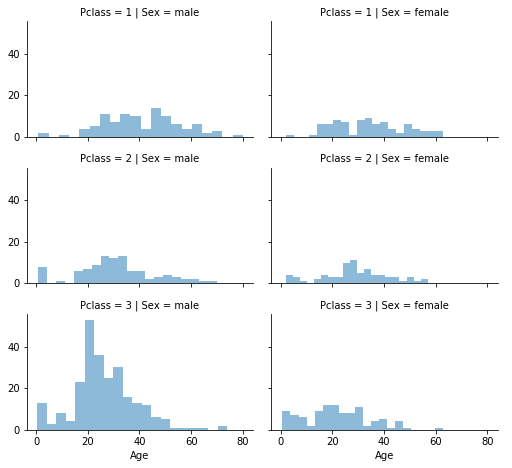

In [87]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [88]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [89]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [90]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


In [91]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i, j] = int(age_guess/0.5 + 0.5) * 0.5
    print(guess_ages)
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset['Age'].isnull()) & (dataset['Sex'] == i) & (dataset['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
    dataset['Age'] = dataset['Age'].astype(int)

dataset.head()

[[40.  30.  25. ]
 [35.  28.  21.5]]
[[42. 28. 24.]
 [41. 24. 22.]]


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,34,0,0,7.8292,Q,1
1,893,3,1,47,1,0,7.0000,S,3
2,894,2,0,62,0,0,9.6875,Q,1
3,895,3,0,27,0,0,8.6625,S,1
4,896,3,1,22,1,1,12.2875,S,3


In [93]:
train_df['AgeBandChk'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBandChk', 'Survived']].groupby(['AgeBandChk'], as_index=False).mean().sort_values(by='AgeBandChk', ascending=True)

,AgeBandChk,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [95]:
for dataset in combine:
    dataset['AgeBand'] = dataset.Age * 0
    dataset.loc[dataset['Age'] <= 16, 'AgeBand'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'AgeBand'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'AgeBand'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'AgeBand'] = 3
    dataset.loc[dataset['Age'] > 64, 'AgeBand'] = 4
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,AgeBandChk
0,0,3,0,22,1,0,7.2500,S,1.0,1,"(16.0, 32.0]"
1,1,1,1,38,1,0,71.2833,C,3.0,2,"(32.0, 48.0]"
2,1,3,1,26,0,0,7.9250,S,2.0,1,"(16.0, 32.0]"
3,1,1,1,35,1,0,53.1000,S,3.0,2,"(32.0, 48.0]"
4,0,3,0,35,0,0,8.0500,S,1.0,2,"(32.0, 48.0]"


In [96]:
train_df = train_df.drop(['AgeBandChk'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,22,1,0,7.2500,S,1.0,1
1,1,1,1,38,1,0,71.2833,C,3.0,2
2,1,3,1,26,0,0,7.9250,S,2.0,1
3,1,1,1,35,1,0,53.1000,S,3.0,2
4,0,3,0,35,0,0,8.0500,S,1.0,2


In [97]:
for dataset in combine:
    dataset['AgeBand*Class'] = dataset.AgeBand * dataset.Pclass

train_df.loc[:, ['AgeBand*Class', 'AgeBand', 'Pclass']].head(10)

,AgeBand*Class,AgeBand,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [98]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [99]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [100]:
freq_port = train_df.Embarked.dropna().mode()[0]
print(freq_port)
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'] .fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

S


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [101]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,AgeBand*Class,FamilySize,IsAlone
0,0,3,0,22,1,0,7.2500,0,1.0,1,3,2,0
1,1,1,1,38,1,0,71.2833,1,3.0,2,2,2,0
2,1,3,1,26,0,0,7.9250,0,2.0,1,3,1,1
3,1,1,1,35,1,0,53.1000,0,3.0,2,2,2,0
4,0,3,0,35,0,0,8.0500,0,1.0,2,6,1,1


In [110]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [107]:
train_df['FareBandChk'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBandChk', 'Survived']].groupby(['FareBandChk'], as_index=False).mean().sort_values(by='FareBandChk', ascending=True)

,FareBandChk,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [109]:
for dataset in combine:
    dataset['FareBand'] = 0
    dataset.loc[dataset['Fare'] <= 7.91, 'FareBand'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'FareBand'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31.0), 'FareBand'] = 2
    dataset.loc[dataset['Fare'] > 31.0, 'FareBand'] = 3

train_df = train_df.drop(['FareBandChk'], axis=1)
combine = [train_df, test_df]

train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,AgeBand*Class,FamilySize,IsAlone,FareBand
0,0,3,0,22,1,0,7.2500,0,1.0,1,3,2,0,0
1,1,1,1,38,1,0,71.2833,1,3.0,2,2,2,0,3
2,1,3,1,26,0,0,7.9250,0,2.0,1,3,1,1,1
3,1,1,1,35,1,0,53.1000,0,3.0,2,2,2,0,3
4,0,3,0,35,0,0,8.0500,0,1.0,2,6,1,1,1
5,0,3,0,25,0,0,8.4583,2,1.0,1,3,1,1,1
6,0,1,0,54,0,0,51.8625,0,1.0,3,3,1,1,3
7,0,3,0,2,3,1,21.0750,0,4.0,0,0,5,0,2
8,1,3,1,27,0,2,11.1333,0,3.0,1,3,3,0,1
9,1,2,1,14,1,0,30.0708,1,3.0,0,0,2,0,2


In [111]:
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, y_train.shape, X_test.shape

((891, 13), (891,), (418, 13))

In [112]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


82.94

In [113]:
# Check Coefficiency

coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,1.734315
7,Title,0.944192
6,Embarked,0.227825
8,AgeBand,0.191149
12,FareBand,0.173503
5,Fare,0.002666
2,Age,-0.020252
4,Parch,-0.159687
9,AgeBand*Class,-0.203963
11,IsAlone,-0.240807


In [115]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_logreg.csv', index=False)

In [116]:
# Support Vector Machine

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train)*100, 2)
acc_svc

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


89.9

In [118]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_svc.csv', index=False)

In [119]:
# k-Nearest Neightbors (k-NN)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

85.86

In [120]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_knn.csv', index=False)

In [121]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

81.14

In [122]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_gaussian.csv', index=False)

In [123]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train)*100, 2)
acc_perceptron

72.5

In [124]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_perceptron.csv', index=False)

In [125]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train)*100, 2)
acc_linear_svc

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


64.76

In [126]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_linear-svc.csv', index=False)

In [127]:
# Stochatic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train)*100, 2)
acc_sgd

69.92

In [128]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_sgd.csv', index=False)

In [129]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train)*100, 2)
acc_decision_tree

98.2

In [130]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_decision_tree.csv', index=False)

In [131]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train)*100, 2)
acc_random_forest

98.2

In [132]:
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('second_submission_random_forest.csv', index=False)

In [133]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,98.20
8,Decision Tree,98.20
0,Support Vector Machines,89.90
1,KNN,85.86
2,Logistic Regression,82.94
4,Naive Bayes,81.14
5,Perceptron,72.50
6,Stochastic Gradient Decent,69.92
7,Linear SVC,64.76


In [135]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Training Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree],
    'Test Score': [0.67464, 0.65071, 0.76076, 
              0.74162, 0.76076, 0.69377, 
              0.71770, 0.67942, 0.68421]})
models.sort_values(by='Test Score', ascending=False)

,Model,Training Score,Test Score
2,Logistic Regression,82.94,0.76076
4,Naive Bayes,81.14,0.76076
3,Random Forest,98.20,0.74162
6,Stochastic Gradient Decent,69.92,0.71770
5,Perceptron,72.50,0.69377
8,Decision Tree,98.20,0.68421
7,Linear SVC,64.76,0.67942
0,Support Vector Machines,89.90,0.67464
1,KNN,85.86,0.65071


In [136]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,AgeBand*Class,FamilySize,IsAlone,FareBand
0,0,3,0,22,1,0,7.2500,0,1.0,1,3,2,0,0
1,1,1,1,38,1,0,71.2833,1,3.0,2,2,2,0,3
2,1,3,1,26,0,0,7.9250,0,2.0,1,3,1,1,1
3,1,1,1,35,1,0,53.1000,0,3.0,2,2,2,0,3
4,0,3,0,35,0,0,8.0500,0,1.0,2,6,1,1,1


In [137]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand,AgeBand*Class,FamilySize,IsAlone,FareBand
0,892,3,0,34,0,0,7.8292,2,1,2,6,1,1,0
1,893,3,1,47,1,0,7.0000,0,3,2,6,2,0,0
2,894,2,0,62,0,0,9.6875,2,1,3,6,1,1,1
3,895,3,0,27,0,0,8.6625,0,1,1,3,1,1,1
4,896,3,1,22,1,1,12.2875,0,3,1,3,3,0,1


In [142]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize', 'Fare', 'Age'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize', 'Fare', 'Age'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Embarked,Title,AgeBand,AgeBand*Class,IsAlone,FareBand
0,0,3,0,0,1.0,1,3,0,0
1,1,1,1,1,3.0,2,2,0,3
2,1,3,1,0,2.0,1,3,1,1
3,1,1,1,0,3.0,2,2,0,3
4,0,3,0,0,1.0,2,6,1,1


In [143]:
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis=1).copy()
X_train.shape, y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [144]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print("acc_log: ", acc_log)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_logreg.csv', index=False)

# Support Vector Machine

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train)*100, 2)
print("acc_svc: ", acc_svc)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_svc.csv', index=False)

# k-Nearest Neightbors (k-NN)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print("acc_knn: ", acc_knn)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_knn.csv', index=False)

# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
print("acc_gaussian: ", acc_gaussian)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_gaussian.csv', index=False)

# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train)*100, 2)
print("acc_perceptron: ", acc_perceptron)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_perceptron.csv', index=False)

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train)*100, 2)
print("acc_linear_svc: ", acc_linear_svc)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_linear-svc.csv', index=False)

# Stochatic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train)*100, 2)
print("acc_sgd: ", acc_sgd)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_sgd.csv', index=False)

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train)*100, 2)
print("acc_decision_tree: ", acc_decision_tree)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_decision_tree.csv', index=False)

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train)*100, 2)
print("acc_random_forest: ", acc_random_forest)
submission = pd.DataFrame({"PassengerId": test_df['PassengerId'], "Survived": y_pred})
submission.to_csv('third_submission_random_forest.csv', index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


acc_log:  81.59
acc_svc:  83.84
acc_knn:  84.51
acc_gaussian:  77.78
acc_perceptron:  80.58


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acc_linear_svc:  81.03
acc_sgd:  81.48
acc_decision_tree:  86.64
acc_random_forest:  86.64


In [150]:
models2 = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Training Score 2': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})

In [151]:
models_merge = pd.merge(models, models2, on='Model')
models_merge.sort_values(by='Training Score', ascending=False)

,Model,Training Score,Test Score,Training Score 2
3,Random Forest,98.20,0.74162,86.64
8,Decision Tree,98.20,0.68421,86.64
0,Support Vector Machines,89.90,0.67464,83.84
1,KNN,85.86,0.65071,84.51
2,Logistic Regression,82.94,0.76076,81.59
4,Naive Bayes,81.14,0.76076,77.78
5,Perceptron,72.50,0.69377,80.58
6,Stochastic Gradient Decent,69.92,0.71770,81.48
7,Linear SVC,64.76,0.67942,81.03


In [ ]:
0.77511